## <center> <font color='purple'> Single Machine Learning Models (Classification Task)</font></center> 
#### <center>Firuz Juraev (Sungkyunkwan Unniversity)</center>

In [1]:
import pandas as pd
import numpy as np 
from numpy import mean
from numpy import std
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif

In [4]:
from sklearn.feature_selection import mutual_info_classif

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score, 
                             f1_score,
                             roc_auc_score, 
                             precision_recall_curve,
                             balanced_accuracy_score,
                             auc)

#### <font color='blue'>Libraries for Critical Diagram 

In [5]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks
from sklearn.metrics import mean_absolute_error

### <font color='purple'>Variables 

In [6]:
#Descriptive Analysis options ------------------------------------------------------------------------------------
doCorrelation = True #Generate visualization of feature correlations (Not recommended for feature sets > 100)
doUA = True #Perform a univariate analysis of features in the dataset 

#Cross Validation run parameters (change as needed) --------------------------------------------------------------
cv_partitions = 10 #number of CV partitions (3-10 recommended)
partition_method = 'S' #Options: random (R), stratified (S), matched (M)
matchName = None #Name of column used for matched CV partitioning. Put None otherwise.

#Data cleaning options--------------------------------------------------------------------------------------------
scaleData = True  #Prescale original dataset values (important for ML and feature importance interpretation of some algorithms)
imputeData = True  #Impute missing values (separate methods used for categorical vs ordinal variables)
autoDetectCategorical = True #keep in mind that this can incorectly identify some ordinal values as being categorical (e.g. tumor state/grade)
categoricalCutoff = 10 #If the number of unique values is greater than this value, the feature is assumed to be ordinal/continuous-valued

#Feature Selection----------------------------------------------------------------------------------------------
algorithms = ['mutual_information','multisurf']
instanceSubset = 2000 #Sample subset size to use with MultiSURF (since they scale quandratically with n)
maxFeaturesToKeep = 50 #Maximum number of features to keep during feature selection - pute None if no max desired)
filterPoorFeatures = True
topResults = 20 #Top features to illustrate in feature selection results figures

#Dataset specific constants (Must be updated for a given dataset)
outcomeLabel = 'DEAD' #i.e. class outcome column label
categoricalOutcome = True  #Is outcome nominal (i.e. discrete/classification) This script will not function correctly if False!
instLabel = None #If data includes instance labels, given respective column name here, otherwise put None
ignore_columns = [] #list of column names to exclude from the analysis (only insert column names if needed, otherwise leave empty)
categorical_variables = [] #Leave empty for 'auto-detect' otherwise list feature names to be treated as categorical.

#Notebook run parameters (i.e. set random seed for notebook replication consistency)
randomSeed = 42
random.seed(randomSeed)

### <font color='purple'>Loading dataset 

In [7]:
train_dataset_upsampled = pd.read_csv("Data/Resampled_neonates_train_data_4.csv")
test_dataset_upsampled = pd.read_csv("Data/Resampled_neonates_test_data_4.csv")

X_train = train_dataset_upsampled.drop(["DEAD"], axis=1) 
y_train = train_dataset_upsampled["DEAD"]

X_test = test_dataset_upsampled.drop(["DEAD"], axis=1) 
y_test = test_dataset_upsampled["DEAD"]

In [8]:
columns = X_train.columns.to_list()

### <font color='purple'>Data Normalization 

In [9]:
Min_max_scaler = MinMaxScaler().fit(X_train)

## Scaling 
X_train_mm_scaled = Min_max_scaler.transform(X_train)
X_test_mm_scaled = Min_max_scaler.transform(X_test)

## Numpy Array to DataFrame 
df_train_mm_scaled = pd.DataFrame(X_train_mm_scaled, columns = columns)
df_test_mm_scaled = pd.DataFrame(X_test_mm_scaled, columns = columns)

### <font color='purple'>Feature Selection 

In [10]:
tain_mm_scaled_df = df_train_mm_scaled[:]
tain_mm_scaled_df["DEAD"] = y_train 

test_mm_scaled_df = df_test_mm_scaled[:] 
test_mm_scaled_df["DEAD"] = y_test


importances = mutual_info_classif(df_train_mm_scaled, y_train)
feat_importance = pd.Series(importances, tain_mm_scaled_df.columns[0:len(tain_mm_scaled_df.columns)-1])
    
feat_importance = feat_importance.sort_values(ascending=False)
    
selected_features = feat_importance[:30]
selected_features_list_mm_scaled = selected_features.index.to_list()


tain_mm_scaled_df[selected_features_list_mm_scaled].head(2)

,temperature_mean,respRate_std,respRate_var,skinTemperature_std,skinTemperature_var,heartRate_std,heartRate_var,sao2_std,bpCuffMean_var,sao2_var,...,bpCuffSystolic_mean,BIRTH_WEIGHT,bpCuffDiastolic_mean,glucometer_mean,sao2_mean,temperature_var,temperature_std,bpCuffMean_mean,PLATELET,D10W_MEAN
0,0.775318,0.422245,0.178291,0.134078,0.017977,0.22911,0.057937,0.097817,0.053294,0.009568,...,0.602649,0.264267,0.457143,0.312593,0.881455,0.015695,0.125281,0.310696,0.281330,0.151138
1,0.709668,0.583964,0.341014,0.086672,0.007512,0.28258,0.086102,0.080938,0.020317,0.006551,...,0.644907,0.437819,0.479330,0.272551,0.926056,0.003770,0.061399,0.351928,0.392157,0.196784


## <font color='purple'>Defining functions 

### <font color='purple'>k-fold Cross Validation partitioning 

In [11]:
def cv_partitioner(td, cv_partitions, partition_method, outcomeLabel, categoricalOutcome, matchName, randomSeed):
    #Partitioning-----------------------------------------------------------------------------------------
    #Shuffle instances to avoid potential biases
    td = td.sample(frac=1, random_state = randomSeed).reset_index(drop=True)
                
    #Temporarily convert data frame to list of lists (save header for later)
    header = list(td.columns.values)
    datasetList = list(list(x) for x in zip(*(td[x].values.tolist() for x in td.columns)))

    #Handle Special Variables for Nominal Outcomes
    outcomeIndex = None
    classList = None
    if categoricalOutcome:
        outcomeIndex = td.columns.get_loc(outcomeLabel)
        classList = []
        for each in datasetList:
            if each[outcomeIndex] not in classList:
                classList.append(each[outcomeIndex])
                
    #Initialize partitions
    partList = [] #Will store partitions
    for x in range(cv_partitions):
        partList.append([])
    
    #Stratified Partitioning Method-----------------------
    if partition_method == 'S':
        if categoricalOutcome: #Discrete outcome
            print("Nominal Stratitifed Partitioning")
            
            #Create data sublists, each having all rows with the same class
            byClassRows = [ [] for i in range(len(classList)) ] #create list of empty lists (one for each class)
            for row in datasetList:
                #find index in classList corresponding to the class of the current row. 
                cIndex = classList.index(row[outcomeIndex])
                byClassRows[cIndex].append(row)

            for classSet in byClassRows:
                currPart = 0
                counter = 0
                for row in classSet:
                    partList[currPart].append(row)
                    counter += 1
                    currPart = counter%cv_partitions
    
        else: # Do stratified partitioning for continuous endpoint data
            print("Error: Stratified partitioning only designed for discrete endpoints. ")    
                
    else:
        print('Error: Requested partition method not found.')
        
        
   #Generation of CV datasets from partitions---------------------------------------------------------------------------
    train_dfs = []

    for part in range(0, cv_partitions):      
        trainList=[]
        tempList = []                 
        for x in range(0,cv_partitions): 
            tempList.append(x)                            
        tempList.pop(part)

        for v in tempList: #for each training partition
            trainList.extend(partList[v])   
        
        train_dfs.append(pd.DataFrame(trainList, columns = header))
            
    return train_dfs #train_dfs, test_dfs 

In [12]:
def get_result_part(train, test, classifier):   
    X_train = train.drop(["DEAD"], axis=1) 
    y_train = train["DEAD"] 
    
    X_test = test.drop(["DEAD"], axis=1) 
    y_test = test["DEAD"]
    
    classifier.fit(X_train, y_train)
    y_preds = classifier.predict(X_test) 
    
    acc = accuracy_score(y_test, y_preds)
    balanced_acc = balanced_accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    
    yproba = classifier.predict_proba(X_test)[::,1] 
    
    print ("Proba: {}".format(yproba[0]))
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, yproba)  
    roc_auc = auc(fpr, tpr) 
    
    results = {'accuracy': acc, 
               'balanced_accuracy': balanced_acc, 
               'precision': precision, 
               'recall': recall, 'f1': f1, 
               'fpr': fpr, 'tpr': tpr, 
               'auc': roc_auc}
    
    return results

In [13]:
def get_results(train_list, test_data, classifiers): 
    k_folds = 10 
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc']) 
    results_set = pd.DataFrame() 
    full_result = pd.DataFrame() 
    for cls in classifiers:   
        accuracy_list = []
        balanced_accuracy_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        fpr_list = [] 
        tpr_list = [] 
        auc_list = [] 
        
        for i in range(0, k_folds):
            result = get_result_part(train_list[i], test_data, cls)
            accuracy_list.append(result['accuracy']) 
            balanced_accuracy_list.append(result['balanced_accuracy'])
            precision_list.append(result['precision']) 
            recall_list.append(result['recall']) 
            f1_list.append(result['f1']) 
            fpr_list.append(result['fpr']) 
            tpr_list.append(result['tpr']) 
            auc_list.append(result['auc']) 
        
        result_table = result_table.append({'classifiers': cls.__class__.__name__,
                                        'fpr': fpr_list, 
                                        'tpr': tpr_list, 
                                        'auc': auc_list}, ignore_index=True)
        
        results_set = results_set.append({'classifiers': cls.__class__.__name__,
                                          'accuracy': round(mean(accuracy_list), 3), 
                                          'accuracy_std': round(std(accuracy_list), 3), 
                                          'precision': round(mean(precision_list), 3), 
                                          'precision_std': round(std(precision_list), 3), 
                                          'recall': round(mean(recall_list), 3), 
                                          'recall_std': round(std(recall_list), 3), 
                                          'f1': round(mean(f1_list), 3), 
                                          'f1_std': round(std(f1_list), 3), 
                                          'auc': round(mean(auc_list), 3), 
                                          'auc_std': round(std(auc_list), 3)}, ignore_index=True)
        
        full_result = full_result.append({'classifiers': cls.__class__.__name__,
                                            'accuracy': accuracy_list}, ignore_index=True) 
    
    result_table.set_index('classifiers', inplace=True)
    return result_table, results_set, full_result    

____________________

## <font color='green'> Single ML models (without any Feature Selection or Optimization)

In [14]:
X_train_mm = df_train_mm_scaled[:]
X_test_mm = df_test_mm_scaled[:]

In [15]:
train_data = X_train_mm[:]
train_data["DEAD"] = y_train

test_data = X_test_mm[:]
test_data["DEAD"] = y_test

train_dfs = cv_partitioner(train_data, cv_partitions, partition_method, "DEAD", categoricalOutcome, matchName, randomSeed)

Nominal Stratitifed Partitioning


In [16]:
classifiers = [GaussianNB(), 
               LogisticRegression(),
               KNeighborsClassifier(), 
               DecisionTreeClassifier(), 
               SVC(probability=True),
               MLPClassifier()]

table, results_table, full_results = get_results(train_dfs, test_data, classifiers)

results_table

Proba: 0.9999999472635054
Proba: 0.9999999604038415
Proba: 0.9999998972292783
Proba: 0.9999999309670381
Proba: 0.9999999438756377
Proba: 0.9999999444727494
Proba: 0.9999999555135314
Proba: 0.9999999710427407
Proba: 0.9999999689253376
Proba: 0.9999999020512907


AttributeError: 'str' object has no attribute 'decode'

__________________________

## <font color='green'> Single ML models (with only Feature Selection)

In [17]:
X_train_mm = df_train_mm_scaled[selected_features_list_mm_scaled][:] ## using only selected features 
X_test_mm = df_test_mm_scaled[selected_features_list_mm_scaled][:]   ## using only selected features 

In [18]:
test_data = X_test_mm[:]
test_data["DEAD"] = y_test

train_data = X_train_mm[:]
train_data["DEAD"] = y_train

train_dfs = cv_partitioner(train_data, cv_partitions, partition_method, "DEAD", categoricalOutcome, matchName, randomSeed)

Nominal Stratitifed Partitioning


In [19]:
classifiers = [GaussianNB(), 
               LogisticRegression(),
               KNeighborsClassifier(), 
               DecisionTreeClassifier(), 
               SVC(probability=True),
               MLPClassifier()]

table, results_table, full_results = get_results(train_dfs, test_data, classifiers)

results_table

,classifiers,accuracy,accuracy_std,precision,precision_std,recall,recall_std,f1,f1_std,auc,auc_std
0,GaussianNB,0.888,0.001,0.920,0.002,0.849,0.000,0.883,0.001,0.966,0.001
1,LogisticRegression,0.923,0.001,0.912,0.002,0.935,0.000,0.924,0.001,0.978,0.001
2,KNeighborsClassifier,0.893,0.000,0.985,0.001,0.797,0.000,0.881,0.000,0.892,0.000
3,DecisionTreeClassifier,0.679,0.029,0.968,0.006,0.371,0.058,0.534,0.061,0.679,0.029
4,SVC,0.848,0.012,0.907,0.005,0.776,0.026,0.836,0.015,0.960,0.002
5,MLPClassifier,0.817,0.026,0.947,0.007,0.672,0.053,0.785,0.037,0.944,0.015


## <font color='green'> Single ML models (with Feature Selection and Optimization)

In [20]:
classifiers = [GaussianNB(var_smoothing=0.1), LogisticRegression(penalty='l2', C=0.002),
               KNeighborsClassifier(n_neighbors=7, leaf_size=40, p=2), 
               DecisionTreeClassifier(criterion='entropy', max_depth=3), 
               SVC(kernel='linear', C=0.007, gamma=0.2, degree=3, probability=True, class_weight='balanced'),
               MLPClassifier(solver='adam', max_iter=11, verbose=10,learning_rate_init=.003)              
              ]

In [21]:
table, results_table, full_results = get_results(train_dfs, test_data, classifiers)

Iteration 1, loss = 0.61204761
Iteration 2, loss = 0.45728338
Iteration 3, loss = 0.37753772
Iteration 4, loss = 0.34150803
Iteration 5, loss = 0.31697255
Iteration 6, loss = 0.30089190
Iteration 7, loss = 0.28357572
Iteration 8, loss = 0.27261058
Iteration 9, loss = 0.26304033
Iteration 10, loss = 0.25554435
Iteration 11, loss = 0.24787839
Iteration 1, loss = 0.61763185
Iteration 2, loss = 0.46246176
Iteration 3, loss = 0.37875224
Iteration 4, loss = 0.33838052
Iteration 5, loss = 0.31476023
Iteration 6, loss = 0.29115034
Iteration 7, loss = 0.27688820
Iteration 8, loss = 0.26601045
Iteration 9, loss = 0.25808766
Iteration 10, loss = 0.25087584
Iteration 11, loss = 0.24406063
Iteration 1, loss = 0.60420790
Iteration 2, loss = 0.45282048
Iteration 3, loss = 0.37256499
Iteration 4, loss = 0.33110591
Iteration 5, loss = 0.30652731
Iteration 6, loss = 0.29063821
Iteration 7, loss = 0.27720641
Iteration 8, loss = 0.26534762
Iteration 9, loss = 0.25672328
Iteration 10, loss = 0.25015397
Ite

### <font color='purple'> Results 

In [22]:
results_table

,classifiers,accuracy,accuracy_std,precision,precision_std,recall,recall_std,f1,f1_std,auc,auc_std
0,GaussianNB,0.904,0.000,0.955,0.001,0.849,0.00,0.899,0.000,0.974,0.000
1,LogisticRegression,0.951,0.001,0.912,0.001,1.000,0.00,0.954,0.001,0.983,0.000
2,KNeighborsClassifier,0.890,0.001,0.979,0.002,0.797,0.00,0.879,0.001,0.894,0.009
3,DecisionTreeClassifier,0.934,0.009,0.928,0.000,0.941,0.02,0.934,0.009,0.936,0.013
4,SVC,0.956,0.001,0.919,0.002,1.000,0.00,0.958,0.001,0.981,0.000
5,MLPClassifier,0.945,0.014,0.901,0.022,1.000,0.00,0.948,0.012,0.985,0.001


### <font color='purple'> ROC Curve 

In [23]:
results_table.auc.to_list()

[0.974, 0.983, 0.894, 0.936, 0.981, 0.985]

In [24]:
def Extract(lst):
    return [item[2] for item in lst]

In [25]:
fpr_results = Extract(table.fpr.to_list())
tpr_results = Extract(table.tpr.to_list())

In [26]:
names = ["NaiveBayes", "LogisticRegression", "KNeighborsClassifier", "DecisionTreeClassifier", 
         "SVC", "MLPClassifier"]


roc_results = {"Models": names, 
              "auc": results_table.auc.to_list(), 
              "fpr": fpr_results, 
              "tpr": tpr_results}

res = pd.DataFrame.from_dict(roc_results)

res.set_index('Models', inplace=True)

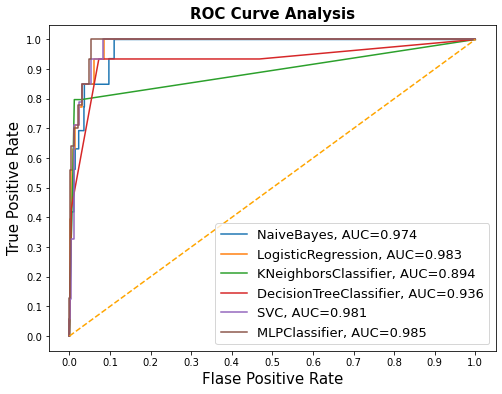

In [27]:
fig = plt.figure(figsize=(8,6))

for i in res.index:
    plt.plot(res.loc[i]['fpr'], 
             res.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, res.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### <font color='purple'> Critical Diagram 

In [28]:
def compare_results(results, lst_models):      
        fried_result = friedmanchisquare(*results)
        
        ranks = np.array([rankdata(-p) for p in results])
        
        # Calculating the average ranks.
        average_ranks = np.mean(ranks, axis=0)

        names = [lst_models[i] + ' - ' + str(round(average_ranks[i], 3)) for i in range(len(average_ranks))]
        
        # This method computes the critical difference for Nemenyi test with alpha=0.1.
        # For some reason, this method only accepts alpha='0.05' or alpha='0.1'.
        cd = compute_CD(average_ranks, n=len(results),alpha='0.05', test='nemenyi')
        
        # This method computes the critical difference for Bonferroni-Dunn test with alpha=0.05.
        # For some reason, this method only accepts alpha='0.05' or alpha='0.1'.
        cd1 = compute_CD(average_ranks, n=len(results), alpha='0.05', test='bonferroni-dunn')
        
        return fried_result, ranks, names, (cd, cd1), average_ranks

In [29]:
def plot_comparisons(fried_result, names, cd, cd1, average_ranks):    
    # This method generates the plot.
    graph_ranks(average_ranks, names=names,
                        cd=cd, width=10, textspace=1.5)
        
    plt.title(f'Friedman-Nemenyi={round(fried_result.pvalue, 4)}\nCD={round(cd, 3)}')
    plt.show()
    
    return

In [30]:
names = ['GaussianNB', 'LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier', 
         'SVC', 'MLPClassifier']

dct_results = {}

for n in names:
    res = full_results[full_results.classifiers == n].accuracy.to_list()[0]
    dct_results[n] = res

results = np.c_[dct_results['GaussianNB'], dct_results['LogisticRegression'], dct_results['KNeighborsClassifier'], 
                dct_results['DecisionTreeClassifier'], dct_results['SVC'], dct_results['MLPClassifier']]

fried_result, ranks, names, (cd, cd1), average_ranks = compare_results(results, names)

In [31]:
res

[0.9579288025889967,
 0.9374325782092773,
 0.959546925566343,
 0.924487594390507,
 0.9336569579288025,
 0.9471413160733549,
 0.9503775620280475,
 0.9228694714131608,
 0.9568500539374326,
 0.9590075512405609]

In [32]:
names

['GaussianNB - 5.0',
 'LogisticRegression - 2.5',
 'KNeighborsClassifier - 6.0',
 'DecisionTreeClassifier - 3.5',
 'SVC - 1.5',
 'MLPClassifier - 2.5']

In [35]:
edited_names = [ 'Naive Bayes - 5.0',
                 'Logistic Regression - 2.5',
                 'KNeighbors Classifier - 6.0',
                 'DecisionTree Classifier - 3.5',
                 'SVC - 1.5',
                 'MLP Classifier - 2.5']

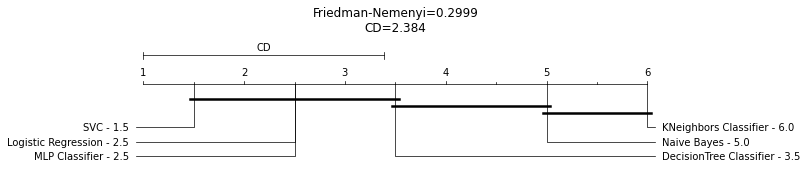

In [36]:
plot_comparisons(fried_result, edited_names, cd, cd1, average_ranks)

_____________________________

### <font color='purple'>Feature Importance 

In [55]:
import shap
import dalex as dx
from eli5.sklearn import PermutationImportance
from yellowbrick.model_selection import FeatureImportances 
import eli5

In [44]:
X_train_mm = df_train_mm_scaled[selected_features_list_mm_scaled][:] ## using only selected features 
X_test_mm = df_test_mm_scaled[selected_features_list_mm_scaled][:]   ## using only selected features 

test_data = X_test_mm[:]
test_data["DEAD"] = y_test

train_data = X_train_mm[:]
train_data["DEAD"] = y_train

train_dfs = cv_partitioner(train_data, cv_partitions, partition_method, "DEAD", categoricalOutcome, matchName, randomSeed)

Nominal Stratitifed Partitioning


In [29]:
classifiers = [GaussianNB(var_smoothing=0.1), LogisticRegression(penalty='l2', C=0.002),
               KNeighborsClassifier(n_neighbors=7, leaf_size=40, p=2), 
               DecisionTreeClassifier(criterion='entropy', max_depth=3), 
               SVC(kernel='linear', C=0.007, gamma=0.2, degree=3, probability=True, class_weight='balanced'),
               MLPClassifier(solver='adam', max_iter=11, verbose=10,learning_rate_init=.003)              
              ]

In [83]:
def explainability(model, train, test): 
    X_train = train.drop(["DEAD"], axis=1) 
    y_train = train["DEAD"] 
    
    X_test = test.drop(["DEAD"], axis=1) 
    y_test = test["DEAD"]
    
    model.fit(X_train, y_train)
    
    # dalex 
    exp = dx.Explainer(model, X_test, y_test)
    exp.model_parts().plot()
    
    # Permutation Importance 
    perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
    fs_scores = eli5.show_weights(perm, feature_names = X_test.columns.tolist())

#     viz = FeatureImportances(model) 
#     viz.fit(X_test, y_test)
#     viz.show()
    
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(X_test)    
#     shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
    
    return fs_scores
    


In [87]:
fs_scores = explainability( MLPClassifier(solver='adam', max_iter=11, verbose=10,learning_rate_init=.003), 
                           train_dfs[4], test_data)
fs_scores

Iteration 1, loss = 0.60126958
Iteration 2, loss = 0.44179063
Iteration 3, loss = 0.36595654
Iteration 4, loss = 0.32691617
Iteration 5, loss = 0.30953643
Iteration 6, loss = 0.28643090
Iteration 7, loss = 0.27341004
Iteration 8, loss = 0.26513609
Iteration 9, loss = 0.25648572
Iteration 10, loss = 0.25077513
Iteration 11, loss = 0.24979380
Preparation of a new explainer is initiated

  -> data              : 1854 rows 30 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1854 values
  -> model_class       : sklearn.neural_network._multilayer_perceptron.MLPClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000018E5E288670> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 2.05e-07, mean = 0.551, max = 1.0
  -> model type        :

Weight,Feature
0.0633 ± 0.0111,sao2_std
0.0469 ± 0.0045,skinTemperature_mean
0.0453 ± 0.0043,respRate_mean
0.0277 ± 0.0074,sao2_var
0.0255 ± 0.0041,D10W_MEAN
0.0237 ± 0.0090,respRate_std
0.0154 ± 0.0077,sao2_mean
0.0150 ± 0.0059,BIRTH_WEIGHT
0.0126 ± 0.0043,temperature_mean
0.0125 ± 0.0037,heartRate_mean
